In [3]:
import matplotlib.pyplot as plt
import numpy as np
from qctrlvisualizer import get_qctrl_style
from scipy.linalg import expm

from qctrl import Qctrl

plt.style.use(get_qctrl_style())

# Define standard matrices
sigma_x = np.array([[0, 1], [1, 0]], dtype=np.complex)
sigma_y = np.array([[0, -1j], [1j, 0]], dtype=np.complex)
sigma_z = np.array([[1, 0], [0, -1]], dtype=np.complex)

# Start a session with the API
qctrl = Qctrl()

### Ideal qubits, gates and measurements (the dream)

An ideal qubit is made up of two basis states which we label $\lvert0\rangle$ and $\lvert1\rangle$. The state of a qubit can then be in any complex linear combination of these states, which we often write down as a vector:

$$
\alpha \lvert0\rangle + \beta \lvert1\rangle = \left( \begin{array}{c} \alpha \\ \beta \end{array} \right)
$$

A quantum computer is always assumed to start all qubits in the $\lvert0\rangle$ state. 

A quantum gate is an operation on the state of a qubit, and is often written as a matrix, we are asking you to find two pulses that implement the following ideal gates.

* A NOT gate:

$$ e^{i\phi_1} \left( \begin{array}{cc} 0 & e^{i \theta} \\ e^{-i \theta} & 0 \end{array} \right) $$

* A Hadamard gate:

$$ \frac{ e^{i\phi_2} }{\sqrt{2}} \left( \begin{array}{cc} e^{i \theta} & e^{i \theta} \\ e^{-i \theta} & -e^{-i \theta} \end{array} \right) $$

Where $\phi_1, \phi_2 \in (0, 2\pi)$ are both arbitrary global phases. We are also allowing you to make gates with an arbitrary phase between the qubits levels parametrized by the angle $\theta \in (0, 2\pi)$. However the *relative* phase between the gates must be fixed, so $\theta$ has to have the same value in the both gates that you implement. Note that normally the Hadamard and NOT gates are defined with $\theta = 0$, we are giving you this freedom because you only have access to projective measurements in the challenge. 

When you measure a qubit, the result is always probabilistic. The probability of reading out a state is equal to the magnitude of its weight. So if we measure the qubit defined above we would get the results $0$ and $1$ with probabilities:

$$ P(0) = |\alpha|^2 \mbox{ and } P(1) = |\beta|^2.$$

Given these definitions, have a go at showing:

* If I start with a qubit in the $\lvert0\rangle$ state and apply a NOT gate, when I perform a measurement I will get the result "1" 100% of the time.

* If I start with a qubit in the $\lvert0\rangle$ state and apply a Hadamard gate, when I perform a measurement I will get the result "0" 50% of the time.

What would I get if I measured a qubit in the $\lvert0\rangle$ state, applied a Hadamard gate, a NOT gate then another Hadamard gate?

### Implementing gates with pulses on an ideal superconducting qubit

Implementing a gate on a real qubit is done *dynamically*. The dynamics of a quantum system is described by the Schrödinger equation:

$$
i \hbar \frac{d}{d t}\vert\psi(t)\rangle = H(t)\vert\psi(t)\rangle,
$$

where $\vert\psi(t)\rangle$ is the time dependent state of the quantum system. For a qubit, it would be described as

$$ \vert\psi(t)\rangle = \alpha(t) \lvert0\rangle + \beta(t) \lvert1\rangle. $$

$H(t)$ is the Hamiltonian of the system and it is described by a time dependent matrix. A Hamiltonian captures the physics of the quantum system. This will include everything: qubits frequencies, the controls we apply to the system,  as well as the noises that come from the environment. To find out how a qubit evolves we need to solve Schrödinger's equation, this in general can be really challenging with time-dependent noisy Hamiltonians. Fortunately, BOULDER OPAL can solve Schrödinger's equation for us, to learn more see the [Simulate dynamics user guide](https://docs.q-ctrl.com/boulder-opal/user-guides/simulate-quantum-dynamics).

To connect Schrödinger's equation to quantum gates, we can use one more trick. Quantum mechanics also states that any evolution of a quantum state can be described with a unitary transformation, so we can replace the dynamics of our state with the dynamics of a unitary transformation $\vert\psi(t)\rangle = U(t) \vert\psi(0)\rangle$. Replacing this in Schrödinger's equation gives us an equation which we can solve to get a quantum gate:

$$
i \hbar \frac{d}{d t}U(t) = H(t)U(t)
$$

Currently the most popular commercial qubits are superconducting circuits, so we will focus on that type of system.

An ideal superconducting qubit has just two levels, labeled $\lvert0\rangle$ and $\lvert1\rangle$. These states refer to different physical states of the superconducting qubits. Depending on how the qubit is built, these labels will refer to the changing charge, flux or phase of the superconducting circuit (for more info see [Superconducting quantum computing](https://en.wikipedia.org/wiki/Superconducting_quantum_computing)). In all cases this quantity becomes quantized and the lowest two energetic levels are what we call the $\lvert0\rangle$ and $\lvert1\rangle$ states. Note that more realistic superconducting qubits can have more than two levels and this can result in leakage (for more info see [Single qubit with leakage](https://docs.q-ctrl.com/boulder-opal/user-guides/simulate-quantum-dynamics#Example-Single-qubit-with-leakage)).

Microwave pulses are then applied to these superconducting qubits to achieve quantum gates like a NOT or Hadamard gate. The effect of a microwave pulse on resonance with an ideal superconducting qubit is described with the following Hamiltonian

$$
\frac{H(t)}{\hbar} = \frac{1}{2} \Omega(t) b + \frac{1}{2} \Omega^\ast(t) b^\dagger,
$$

where $\Omega(t) = I(t) + i Q(t)$ is the time-dependent microwave drive also called the *complex Rabi rate* because it relates to [Rabi oscillations](https://en.wikipedia.org/wiki/Rabi_cycle), made of two real components labeled $I(t)$ and $Q(t)$, and $b = \left( \begin{array}{cc} 0 & 1 \\ 0 & 0 \end{array} \right)$ is a lowering operator.  

If we set the complex Rabi rate to be constant $\Omega(t) = \omega$ we can solve Schrödinger's equation and get the following unitary

$$
U(t) = \left( \begin{array}{cc} \cos(\omega t/2) & -i\sin(\omega t/2) \\ -i\sin(\omega t/2) & \cos(\omega t/2) \end{array} \right).
$$

By simply waiting the appropriate time we can then generate a NOT gate, we just set $t = \pi/\omega$. Getting a Hadamard gate is a bit more complicated. Once approach is to apply $\Omega = i\omega$ for $t = \pi/2\omega$, then $\Omega = \omega$ for $t = \pi/\omega$. 

### Simulating an ideal superconducting qubit

Let's bring everything we have learned together and look at a simulation of a pulse being applied to an ideal superconducting qubit with a simulation using BOULDER OPAL. We will wrap this whole simulation in a single function call that takes a pulse and returns both a unitary and a series of projective measurements. In a realistic simulation you would *only* get the projective measurements. To learn more about how to setup simulations in BOULDER OPAL read the [Simulate quantum dynamics user guide](https://docs.q-ctrl.com/boulder-opal/user-guides/simulate-quantum-dynamics).

In [28]:
def simulate_ideal_qubit(
    duration=1, values=np.array([np.pi]), shots=1024, repetitions=1
):

    b = np.array([[0, 1], [0, 0]])  # Lowering operator
    initial_state = np.array([[1], [0]])  # Initial state of qubit in |0>

    with qctrl.create_graph() as graph:

        # Create time dependent \Omega(t)
        drive = qctrl.operations.pwc_signal(duration=duration, values=values)

        # Construct Hamiltonian (\Omega(t) b + \Omega^*(t) b^\dagger)/2
        hamiltonian = qctrl.operations.pwc_operator_hermitian_part(
            qctrl.operations.pwc_operator(signal=drive, operator=b)
        )

        # Solve Schrodinger's equation and get total unitary at the end
        unitary = qctrl.operations.time_evolution_operators_pwc(
            hamiltonian=hamiltonian,
            sample_times=np.array([duration]),
        )[-1]
        unitary.name = "unitary"

        # Repeat final unitary
        repeated_unitary = np.eye(2)
        for _ in range(repetitions):
            repeated_unitary = repeated_unitary @ unitary
        repeated_unitary.name = "repeated_unitary"

        # Calculate final state.
        state = repeated_unitary @ initial_state

        # Calculate final populations.
        populations = qctrl.operations.abs(state[:, 0]) ** 2
        # Normalize populations because of numerical precision
        norm = qctrl.operations.sum(populations)
        populations = populations / norm
        populations.name = "populations"

    # Evaluate graph.
    result = qctrl.functions.calculate_graph(
        graph=graph,
        output_node_names=["unitary", "repeated_unitary", "populations"],
    )

    # Extract outputs.
    unitary = result.output["unitary"]["value"]
    repeated_unitary = result.output["repeated_unitary"]["value"]
    populations = result.output["populations"]["value"]

    # Sample projective measurements.
    measurements = np.random.choice(2, size=shots, p=populations)

    results = {"unitary": unitary, "measurements": measurements}

    return results

#### Plotting our ideal pulses

We have created a method for simulating our ideal qubit: `simulate_ideal_qubit`. This method takes as inputs the duration and a set of values for the complex pulse driving the qubit. In the method, the total pulse duration is evenly divided in segments, with their values being a piecewise constant part of a continuous function. To get a clearer picture of how this works, let's plot an example pulse.

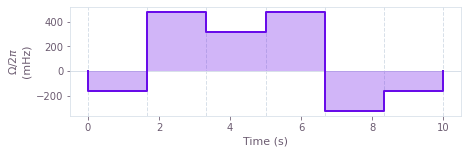

In [11]:
duration = 10
values = np.array([-1, 3, 2, 3, -2, -1])


def get_pulse_plot_dict(name="default", duration=1, values=np.array([1.0])):
    segments = len(values)
    segment_durations = duration / segments
    pulse_plot_dict = {
        name: [{"duration": segment_durations, "value": v} for v in values]
    }
    return pulse_plot_dict


example_pulse = get_pulse_plot_dict(name="$\Omega$", duration=duration, values=values)

fig = plt.figure()
plot_controls(fig, example_pulse, polar=False)
plt.show()

Now that we understand how the duration and values relate to the complex Rabi rate $\Omega(t)$, we can create and plot pulses that we think should implement ideal NOT and Hadamard gates.

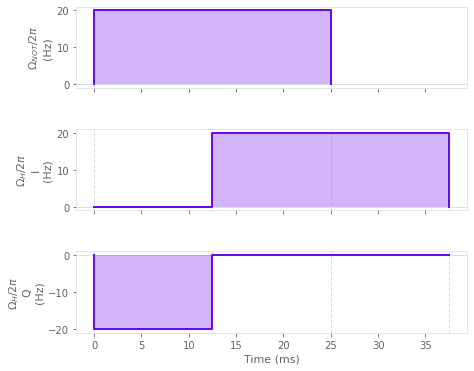

In [43]:
max_rabi_rate = 20 * 2 * np.pi  # MHz
not_duration = np.pi / (max_rabi_rate)  # us
not_values = np.array([max_rabi_rate])
h_duration = 3 * np.pi / (2 * max_rabi_rate)  # us
h_values = np.array([-1j * max_rabi_rate, max_rabi_rate, max_rabi_rate])

not_pulse = get_pulse_plot_dict(
    name="$\Omega_{NOT}$", duration=not_duration, values=not_values
)
h_pulse = get_pulse_plot_dict(name="$\Omega_{H}$", duration=h_duration, values=h_values)
both_pulses = {**not_pulse, **h_pulse}

fig = plt.figure()
plot_controls(fig, both_pulses, polar=False)
plt.show()

#### Simulation of an ideal NOT and Hadamard gate

Let's now check that we get the correct unitary if we apply our ideal pulses as we derived above:

In [44]:
shots = 1024

In [45]:
not_results = simulate_ideal_qubit(
    duration=not_duration, values=not_values, shots=shots
)
h_results = simulate_ideal_qubit(duration=h_duration, values=h_values, shots=shots)

Your task calculate_graph has completed in 3s.


Your task calculate_graph has completed in 3s.


In [46]:
error_norm = (
    lambda operate_a, operator_b: 1
    - np.abs(np.trace((operate_a.conj().T @ operator_b)) / 2) ** 2
)

realised_not_gate = not_results["unitary"]
ideal_not_gate = np.array([[0, 1], [1, 0]])
not_error = error_norm(realised_not_gate, ideal_not_gate)
realised_h_gate = h_results["unitary"]
ideal_h_gate = (1 / np.sqrt(2)) * np.array([[1, 1], [1, -1]])
h_error = error_norm(realised_h_gate, ideal_h_gate)

print("Realised NOT Gate:")
print(realised_not_gate)
print("Ideal NOT Gate:")
print(ideal_not_gate)
print("NOT Gate Error:" + str(not_error) + "\n")
print("Realised H Gate:")
print(realised_h_gate)
print("Ideal H Gate:")
print(ideal_h_gate)
print("H Gate Error:" + str(h_error))

Realised NOT Gate:
[[2.83276945e-16+0.j 0.00000000e+00-1.j]
 [0.00000000e+00-1.j 2.83276945e-16+0.j]]
Ideal NOT Gate:
[[0 1]
 [1 0]]
NOT Gate Error:4.440892098500626e-16

Realised H Gate:
[[ 2.22044605e-16-0.70710678j -2.22044605e-16-0.70710678j]
 [ 2.22044605e-16-0.70710678j  2.22044605e-16+0.70710678j]]
Ideal H Gate:
[[ 0.70710678  0.70710678]
 [ 0.70710678 -0.70710678]]
H Gate Error:1.1102230246251565e-15


You can see that the unitaries we wanted were generated from these pulses. Unfortunately in a real experiment we won't get direct access to the unitaries but only to the results of projective measurements performed on the system.

#### Checking how good our gates were with projective measurements

On a real quantum computer you only get access to the projective measurements not direct access to the unitary. There are many techniques out there to try and estimate the unitary or its quality (Have a look at [quantum tomography](https://en.wikipedia.org/wiki/Quantum_tomography) or [randomized benchmarking](https://en.wikipedia.org/wiki/Randomized_benchmarking)), but they tend to take a lot of measurements and require many assumptions. 

Here we are going to show you some quicker ways of getting a precise estimate. We start by making a function that, given a list of measurements 1 and 0, estimates the probability that a 1 would be returned, and an error in that estimate (assuming the central limit theorem). We apply this method to the results we previously got.

In [8]:
not_measurements = not_results["measurements"]
h_measurements = h_results["measurements"]


def estimate_probability_of_one(measurements):
    size = len(measurements)
    probability = np.mean(measurements)
    standard_error = np.std(measurements) / np.sqrt(size)
    return (probability, standard_error)


not_probability, not_standard_error = estimate_probability_of_one(not_measurements)
h_probability, h_standard_error = estimate_probability_of_one(h_measurements)

In [9]:
print("NOT estimated probability of getting 1:" + str(not_probability))
print("NOT estimate standard error:" + str(not_standard_error))
print("H estimated probability of getting 1:" + str(h_probability))
print("H estimate standard error:" + str(h_standard_error))

NOT estimated probability of getting 1:1.0
NOT estimate standard error:0.0
H estimated probability of getting 1:0.52734375
H estimate standard error:0.015601617483501556


Both of our results appear to be right. We got a result with our NOT gate always returning 1, this is what we were expecting. We also got a result for our H gate returning a result of 1 50% of the time, within the standard error. 

However the problem here is that the precision on the error for the H gate, on the order of $10^{-16}$ is much much smaller than our standard error estimate, on the order of $10^{-2}$. Taking more measurements might give us a more precise answer. But the precision of the standard error scales poorly with the number of measurements $M$, as it goes as $1/\sqrt{M}$. So that's little reward for a lot more measurements. Furthermore, if we have additional errors like State Preparation and Measurement (SPAM) errors (which we will introduce latter) things might scale even worse.

#### Repetition makes perfect

The solution to this problem is the extra input to the `simulate_ideal_qubit` method,  the `repetition`. In a real experiment we can repeat a pulse to implement a gate multiple times before we measure. If we repeat a gate, we can effectively boost the error signal. For example, consider repeating an imperfect H gate 101 times, if it was perfect we would still expect to get a 1 with probability 0.5, but if there was a small error $\epsilon$ on the gate, we would expect to get a 1 with probability $0.5 + 101 \epsilon$. Hence we can use repetition to effective boost the signal of our error!

Let's demonstrate this working by looking at a Hadamard gate with a small error and use a few different repetitions to detect the error with the same number of measurement shots as above.

In [10]:
epsilon = 0.003
h_duration = (np.pi + epsilon) / (2 * max_rabi_rate)  # us

repetitions = np.array([1, 17, 127])
repetition_results = []

In [11]:
for reps in repetitions:
    repetition_results.append(
        simulate_ideal_qubit(
            duration=h_duration, values=values, shots=shots, repetitions=reps
        )
    )

  0%|          | 0/100 [00:00<?, ?it/s]

Your task calculate_graph has completed in 3s.


  0%|          | 0/100 [00:00<?, ?it/s]

Your task calculate_graph has completed in 3s.


  0%|          | 0/100 [00:00<?, ?it/s]

Your task calculate_graph has completed in 3s.


In [12]:
probability_estimates = np.zeros(3)
standard_errors = np.zeros(3)

for count, result in enumerate(repetition_results):
    probability_estimates[count], standard_errors[count] = estimate_probability_of_one(
        result["measurements"]
    )

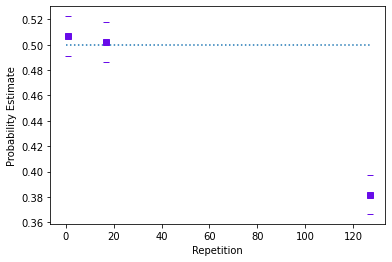

In [13]:
plt.plot(repetitions, probability_estimates, "s", color="#680CE9")
plt.plot(repetitions, probability_estimates + standard_errors, "_", color="#680CE9")
plt.plot(repetitions, probability_estimates - standard_errors, "_", color="#680CE9")
plt.hlines(0.5, 0, 127, linestyle=":")
plt.xlabel("Repetition")
plt.ylabel("Probability Estimate")
plt.show()

Here we can see that the repetition process is successfully revealing an error that would not have been outside of the standard error with just one use of the gate. You can also do a line fit to these repetition plots to get a more precise estimate of the error on your gate. 

#### No need for quantum control without noise and errors

There is nothing more we can do with this ideal model. We have already achieved perfect gates. If we want to apply quantum control with BOULDER OPAL we have to add some noise and errors to our qubit model. 

### More realistic qubits, gates and measurements (the reality)

Let's make this model more realistic and include some noise and errors. We won't give a complete mathematical model because it will get too complicated. Instead, we will provide a list of the additional complications we are going to add to the model then jump straight to the code itself.

1. In realistic superconducting devices the Rabi rate that you drive the qubit with is not normally known. Instead you normally set some voltages on your microwave signal generator and you have to figure out how they relate to the Rabi rate. These are usually normalized between -1 and 1. To learn how to determine the Rabi rate of your qubit have a look at the [Pulse calibration application note](https://docs.q-ctrl.com/boulder-opal/application-notes/control-hardware-pulse-calibration).

2. One step we didn't talk about is tuning your microwave on resonance with your superconducting qubit. Even after tuning your microwave drive to be on resonance with your microwave drive, there might be a small detuning error that can drift slowly over time. This manifests as an extra term in the Hamiltonian that looks like:
    $$
    \frac{H(t)}{\hbar} = \epsilon_D(t) b^\dagger b + \frac{1}{2} \Omega(t) b + \frac{1}{2} \Omega(t) b^\dagger 
    $$
    For most experiments this $\epsilon_D(t)$ changes so slowly that they can be treated as effectively constant for a single experiment.  
    
3. Even after calibrating your Rabi rate, there can also be a small amplitude error in the $I$ and $Q$ channels that make up your complex Rabi rate. These errors can be independent and look like:
    $$
    \frac{H(t)}{\hbar} = \frac{1}{2} (I(t)(1 + \epsilon_I(t)) + Q(t)(1 + \epsilon_Q(t))) b + \mbox{ h. c. } 
    $$
    where h. c. means hermitian conjugate of the previous term. Again, $\epsilon_I(t)$ and $\epsilon_Q(t)$ change so slowly that they can be basically treated as effectively constant for a single experiment.  

4. When using superconducting qubits, microwaves are typically sent down control lines that have bandwidth limits. This means that signals with sudden changes tend not to work very well when used on a real device. We can add these bandwidth limits onto any control lines in BOULDER OPAL using the linear filter feature. To learn more about this feature have a look at the [Pulse optimization under realistic experimental constraints application note](https://docs.q-ctrl.com/boulder-opal/application-notes/control-hardware-pulse-optimization-under-realistic-experimental-constraints)

5. Another critical issue on quantum computers is state preparation and measurement (SPAM) errors. These occur when the qubit is not perfectly prepared in the ground state at the beginning of computation, this often gets worse when the quantum computer heats up. There can also be many errors introduced during the measurement state. Superconducting qubits make measurements by driving a resonator that is coupled to the qubit, the state of the qubit affects the frequency of the resonator, which allows us to read out the qubits state. This process is not perfect and sometimes a 1 is incorrectly detected as a 0 and vice versa. These errors are best modeled using a [confusion matrix](https://en.wikipedia.org/wiki/Confusion_matrix). 

### Simulating a more realistic superconducting qubit

Now let's code up a more realistic superconducting qubit that has all of these errors. 

In [14]:
def simulate_more_realistic_qubit(
    duration=1, values=np.array([np.pi]), shots=1024, repetitions=1
):

    # 1. Limits for drive amplitudes
    assert np.amax(values) <= 1.0
    assert np.amin(values) >= -1.0
    max_drive_amplitude = 2 * np.pi * 20  # MHz

    # 2. Dephasing error
    dephasing_error = -2 * 2 * np.pi  # MHz

    # 3. Amplitude error
    amplitude_i_error = 0.98
    amplitude_q_error = 1.03

    # 4. Control line bandwidth limit
    cut_off_frequency = 2 * np.pi * 10  # MHz
    resample_segment_count = 1000

    # 5. SPAM error confusion matrix
    confusion_matrix = np.array([[0.99, 0.01], [0.02, 0.98]])

    # Lowering operator
    b = np.array([[0, 1], [0, 0]])
    # Number operator
    n = np.diag([0, 1])
    # Initial state
    initial_state = np.array([[1], [0]])

    with qctrl.create_graph() as graph:
        # Apply 1. max Rabi rate.
        values = values * max_drive_amplitude

        # Apply 3. amplitude errors.
        values_i = np.real(values) * amplitude_i_error
        values_q = np.imag(values) * amplitude_q_error
        values = values_i + 1j * values_q

        # Apply 4. bandwidth limits
        drive_unfiltered = qctrl.operations.pwc_signal(duration=duration, values=values)
        drive_filtered = qctrl.operations.convolve_pwc(
            pwc=drive_unfiltered,
            kernel_integral=qctrl.operations.sinc_integral_function(cut_off_frequency),
        )
        drive = qctrl.operations.discretize_stf(
            drive_filtered, duration=duration, segments_count=resample_segment_count
        )

        # Construct microwave drive
        drive_term = qctrl.operations.pwc_operator_hermitian_part(
            qctrl.operations.pwc_operator(signal=drive, operator=b)
        )

        # Construct 2. dephasing term.
        dephasing_term = qctrl.operations.constant_pwc_operator(
            operator=dephasing_error * n,
            duration=duration,
        )

        # Construct Hamiltonian.
        hamiltonian = qctrl.operations.pwc_sum(
            [
                drive_term,
                dephasing_term,
            ]
        )

        # Solve Schrodinger's equation and get total unitary at the end
        unitary = qctrl.operations.time_evolution_operators_pwc(
            hamiltonian=hamiltonian,
            sample_times=np.array([duration]),
        )[-1]
        unitary.name = "unitary"

        # Repeat final unitary
        repeated_unitary = np.eye(2)
        for _ in range(repetitions):
            repeated_unitary = repeated_unitary @ unitary
        repeated_unitary.name = "repeated_unitary"

        # Calculate final state.
        state = repeated_unitary @ initial_state

        # Calculate final populations.
        populations = qctrl.operations.abs(state[:, 0]) ** 2
        # Normalize populations
        norm = qctrl.operations.sum(populations)
        populations = populations / norm
        populations.name = "populations"

    # Evaluate graph.
    result = qctrl.functions.calculate_graph(
        graph=graph,
        output_node_names=["unitary", "repeated_unitary", "populations"],
    )

    # Extract outputs.
    unitary = result.output["unitary"]["value"]
    repeated_unitary = result.output["repeated_unitary"]["value"]
    populations = result.output["populations"]["value"]

    # Sample projective measurements.
    true_measurements = np.random.choice(2, size=shots, p=populations)
    measurements = np.array(
        [np.random.choice(2, p=confusion_matrix[m]) for m in true_measurements]
    )

    results = {"unitary": unitary, "measurements": measurements}

    return results

#### Trying the ideal approach

Let's see what happens when we try and use the same type of pulse that worked for the ideal qubit. We will assume that we have already used the techniques in the [Pulse calibration application note](https://docs.q-ctrl.com/boulder-opal/application-notes/control-hardware-pulse-calibration) to determine that the maximum Rabi rate is $20\times 2\pi$ MHz. If we use the same pulses we get

In [15]:
max_rabi_rate = 20 * 2 * np.pi  # MHz
not_duration = np.pi / (max_rabi_rate)  # us
h_duration = np.pi / (2 * max_rabi_rate)  # us
shots = 1024

values = np.array([1.0])

In [16]:
not_results = simulate_more_realistic_qubit(
    duration=not_duration, values=values, shots=shots
)
h_results = simulate_more_realistic_qubit(
    duration=h_duration, values=values, shots=shots
)

  0%|          | 0/100 [00:00<?, ?it/s]

Your task calculate_graph has completed in 4s.


  0%|          | 0/100 [00:00<?, ?it/s]

Your task calculate_graph has completed in 3s.


In [17]:
realised_not_gate = not_results["unitary"]
ideal_not_gate = np.array([[0, -1j], [-1j, 0]])
not_error = error_norm(realised_not_gate, ideal_not_gate)
realised_h_gate = h_results["unitary"]
ideal_h_gate = (1 / np.sqrt(2)) * np.array([[1, -1j], [-1j, 1]])
h_error = error_norm(realised_h_gate, ideal_h_gate)

not_measurements = not_results["measurements"]
h_measurements = h_results["measurements"]
not_probability, not_standard_error = estimate_probability_of_one(not_measurements)
h_probability, h_standard_error = estimate_probability_of_one(h_measurements)

print("Realised NOT Gate:")
print(realised_not_gate)
print("Ideal NOT Gate:")
print(ideal_not_gate)
print("NOT Gate Error:" + str(not_error))
print("NOT estimated probability of getting 1:" + str(not_probability))
print("NOT estimate standard error:" + str(not_standard_error) + "\n")

print("Realised H Gate:")
print(realised_h_gate)
print("Ideal H Gate:")
print(ideal_h_gate)
print("H Gate Error:" + str(h_error))
print("H estimated probability of getting 1:" + str(h_probability))
print("H estimate standard error:" + str(h_standard_error))

Realised NOT Gate:
[[0.75412104-0.02524955j 0.1026601 -0.64817036j]
 [0.1026601 -0.64817036j 0.70940919+0.25704996j]]
Ideal NOT Gate:
[[ 0.+0.j -0.-1.j]
 [-0.-1.j  0.+0.j]]
NOT Gate Error:0.5693360860922008
NOT estimated probability of getting 1:0.41015625
NOT estimate standard error:0.0153706834828011

Realised H Gate:
[[0.98219782-0.00092913j 0.01473832-0.18726817j]
 [0.01473832-0.18726817j 0.96995998+0.15456728j]]
Ideal H Gate:
[[0.70710678+0.j         0.        -0.70710678j]
 [0.        -0.70710678j 0.70710678+0.j        ]]
H Gate Error:0.31912041750757547
H estimated probability of getting 1:0.04296875
H estimate standard error:0.006337083668172564


The more realistic qubit now has many more errors. You can use quantum control, and BOULDER OPAL, to fix these errors and improve the performance of this more realistic qubit!

### Quantum Control Approaches

There are many different ways to use quantum control to improve the performance of a realistic qubit. Here we present three major approaches with a brief discussion of the advantages and disadvantages. It's up to you to decide which approach interests you the most! We recommend trying the control technique you're going to apply to the more realistic qubit above first, then when you understand how it works, try applying it to the qubit in the cloud for the challenge.

#### Optimal Control

Optimal control is best used when you have a detailed model of the system you are trying to improve. To start you might want to assume that you already have a detailed model of the more realistic qubit presented above. You can then follow the instructions in the [Optimize controls user guide](https://docs.q-ctrl.com/boulder-opal/user-guides/optimize-controls) which explains how to optimize any quantum system that you can program as a graph. If you have a good model, optimal control will typically be the quickest path to get a high fidelity gate. However when you're working with a real device, you normally don't have perfect knowledge of your system's Hamiltonian, and often parameters in your system, like the Rabi rate, can slowly drift over time.

If you want to try and apply optimal control to a real qubit, you'll also need an accurate model. BOULDER OPAL has system identification feature, described in the [System identification application note](https://docs.q-ctrl.com/boulder-opal/application-notes/control-hardware-system-identification) that allows you to identify the terms in a Hamiltonian, which can then be used to derive optimized control. System identification can be problematic when using noisy results, so only take this on if you like a real challenge.

#### Robust Control

Robust control is best used when you have partial knowledge of the system you are trying to improve. For example, you may know that you have a qubit undergoing dephasing and amplitude errors and that there is some bandwidth limit on the control lines. In this case you can design a control that achieves a high fidelity operation even if you don't exactly know what the current dephasing or amplitude errors are. 

A great place to start with this approach is the [Incorporating smoothing via linear filters on control signals example](https://docs.q-ctrl.com/boulder-opal/user-guides/optimize-controls#Example-Incorporating-smoothing-via-linear-filters-on-control-signals) in the [Optimize controls user guide](https://docs.q-ctrl.com/boulder-opal/user-guides/optimize-controls). This shows you how to optimize a pulse which is robust to dephasing and band-limited. If you also would like an example of adding amplitude error robustness have a look at the [CRAB Optimization example](https://docs.q-ctrl.com/boulder-opal/user-guides/optimize-controls#Example-CRAB-optimization) in the same notebook. You don't need any knowledge of the Rabi rate to design robust pulses to dephasing and amplitude errors. Furthermore, as long as you set the bandwidth of filter low enough when optimizing the pulse, you won't be affected by bandwidth limits on your control lines.

When you actually want to test a robust control pulse you will need to calibrate it. This process is detailed in the [Pulse calibration application note](https://docs.q-ctrl.com/boulder-opal/application-notes/control-hardware-pulse-calibration). 

A great overview of this approach applied to improve the performance of a real qubit accessed through the IBM Quantum Experience is in the [Suppressing errors on real quantum computers webinar](https://youtu.be/WabKiPoBF4Y), which can be found in the [Q-CTRL learning center](https://q-ctrl.com/learning-center/). 

#### Learning control

Learning control, also often called closed-loop automated optimization, is a different approach to both optimal and robust control. It does not assume a model of the qubit at all. Instead, closed-loop automated optimization can be used to directly learn the best control from the qubit itself. The best place to get started with this approach is the [Automated closed-loop hardware optimization of quantum devices user guide](https://docs.q-ctrl.com/boulder-opal/user-guides/automate-closed-loop-hardware-optimization-of-quantum-devices). This gives an overview of using automated optimization to improve the performance of a simulated qubit.

When doing closed-loop automated optimization it is very important that you pick the right cost function for the automated optimization algorithm. You should review the "Repetition makes perfect" section to learn how to effectively estimate the fidelity of a unitary from realistic projective measurements from a qubit.

A great overview of this approach applied to improve the performance of a real qubit accessed through the IBM Quantum Experience is in the [Suppressing errors on real quantum computers webinar](https://youtu.be/WabKiPoBF4Y), which can be found in the [Q-CTRL learning center](https://q-ctrl.com/learning-center/). Q-CTRL has implemented some sophisticated machine learning algorithms under the hood to ensure our automated optimization routines converge as quickly as possible, to learn more about other experiments our automated optimization features has been used on you should watch the [Automated closed-loop optimization webinar](https://youtu.be/CRWVmoqTen4).

### The more realistic qubit vs the qubit in the cloud

In this document we have presented code for a more realistic qubit. The qubit in the cloud for the challenge itself *is even more complicated and realistic*. It contains all the affects that the more realistic qubit has, along with a few additional complications that a real superconducting qubit faces.

## Accessing the qubit in the cloud (the challenge!)

The challenge is to create pulses that implement high fidelity Hadamard and NOT gates on a qubit in the cloud provided through BOULDER OPAL. Here we show you how to send pulses to the qubit in the cloud and get measurement results. 

In what follows we will show you how to create a series of controls (pulses), send them to the qubit in the cloud, and analyze the results of the experiment. We begin by importing some basic modules and starting a session with the BOULDER OPAL Q-CTRL API.

We begin by establishing some parameters for our pulses:
- `control_count`: How many controls we create.
- `segment_count`: How many segments each pulse is split into.
- `duration`: The duration (in ns) of each pulse.
- `shot_count`: How many projective measurements we take at the end of each control.

You will probably want to change these values later depending on how you approach the challenge. For instance, the larger the `shot_count` is, the more measurements we get out of the qubit for each control (we only keep it small here so that the experiment results are easier to visualize).


In [37]:
control_count = 5
segment_count = 16
duration = 30.0
shot_count = 32

We now create a list of controls to send to the qubit. Each of them is a dictionary with a `duration` (how long the pulse is) and an array of (complex) `values` indicating the strength of the pulse in piecewise-constant intervals. Here we use random pulses, so we do not expect them to perform very well at all or implement any particular gate.

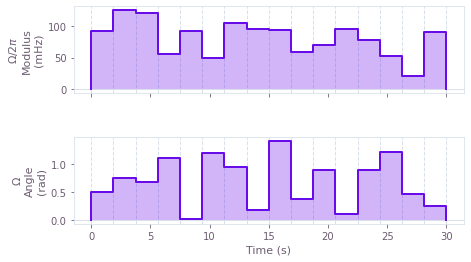

In [38]:
controls = []
for k in range(control_count):
    # Create a random string of complex numbers for each controls.
    real_part = np.random.random(size=[segment_count])
    imag_part = np.random.random(size=[segment_count])
    values = 0.15 * k * (real_part + 1j * imag_part)

    controls.append({"duration": duration, "values": values})

# Plot the last control as an example.
plot_controls(
    figure=plt.figure(),
    controls={
        "$\Omega$": [
            {"duration": duration / segment_count, "value": value} for value in values
        ]
    },
)

We can now send those controls to the qubit and get back the results of applying each one of them. We put the returned object in `experiment_results`.

In [39]:
# Obtain the results of the experiment.
experiment_results = qctrl.functions.calculate_qchack_measurements(
    controls=controls,
    shot_count=shot_count,
)

Your task calculate_qchack_measurements has completed in 4s.


What we are interested in are the results of the measurements on the qubit, which are in `experiment_results.measurements`. This is a list containing, for each control that we have sent to the qubit, the result of `shot_count` measurements, that is, whether the qubit was found to be in state $|0\rangle$, $|1\rangle$, or $|2\rangle$.

In [40]:
measurements = experiment_results.measurements
for k, measurement_counts in enumerate(measurements):
    print(f"control #{k}: {measurement_counts}")

control #0: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
control #1: [0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0]
control #2: [1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0]
control #3: [0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1]
control #4: [0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0]


In [41]:
for k, measurement_counts in enumerate(measurements):
    p0 = measurement_counts.count(0) / shot_count
    p1 = measurement_counts.count(1) / shot_count
    p2 = measurement_counts.count(2) / shot_count
    print(f"control #{k}: P(|0>) = {p0:.2f}, P(|1>) = {p1:.2f}, P(|2>) = {p2:.2f}")

control #0: P(|0>) = 1.00, P(|1>) = 0.00, P(|2>) = 0.00
control #1: P(|0>) = 0.75, P(|1>) = 0.25, P(|2>) = 0.00
control #2: P(|0>) = 0.53, P(|1>) = 0.47, P(|2>) = 0.00
control #3: P(|0>) = 0.34, P(|1>) = 0.66, P(|2>) = 0.00
control #4: P(|0>) = 0.59, P(|1>) = 0.41, P(|2>) = 0.00


In [42]:
repetitions = [1, 4, 16, 32, 64]

controls = []
# Create a random string of complex numbers for all control,
# but set a different repetition_count for each control.
real_part = np.random.random(size=[segment_count])
imag_part = np.random.random(size=[segment_count])
values = 0.5 * (real_part + 1j * imag_part)

for repetition_count in repetitions:
    controls.append(
        {"duration": duration, "values": values, "repetition_count": repetition_count}
    )

experiment_results = qctrl.functions.calculate_qchack_measurements(
    controls=controls,
    shot_count=shot_count,
)

for repetition_count, measurement_counts in zip(
    repetitions, experiment_results.measurements
):
    p0 = measurement_counts.count(0) / shot_count
    p1 = measurement_counts.count(1) / shot_count
    p2 = measurement_counts.count(2) / shot_count
    print(
        f"With {repetition_count:2d} repetitions: P(|0>) = {p0:.2f}, P(|1>) = {p1:.2f}, P(|2>) = {p2:.2f}"
    )

Your task calculate_qchack_measurements has completed in 4s.
With  1 repetitions: P(|0>) = 0.41, P(|1>) = 0.56, P(|2>) = 0.03
With  4 repetitions: P(|0>) = 0.56, P(|1>) = 0.44, P(|2>) = 0.00
With 16 repetitions: P(|0>) = 0.88, P(|1>) = 0.12, P(|2>) = 0.00
With 32 repetitions: P(|0>) = 0.38, P(|1>) = 0.62, P(|2>) = 0.00
With 64 repetitions: P(|0>) = 0.81, P(|1>) = 0.16, P(|2>) = 0.03


## Submission

We recommend doing your submission through a Github repository. You can create an account by going to [GitHub's home page](https://github.com/). If you're new to GitHub the QCHack team has provided a [tutorial on the GitHub basics](https://github.com/yaleqc/github-basics) to get you started. We recommend using [the Github GUI client](https://desktop.github.com/) to make life a bit easier if you're not used to using a command line.

Make a repository named `qctrl-qchack-<team_name>` with a description `Q-CTRL QCHack Challenge <team_name> entry`. Where `<team_name>` is your team name. 

In the root folder there should be three essential files:

1. `not_gate_pulse.json` which contains the duration and values of your best NOT gate
2. `h_gate_pulse.json` which contains the duration and values of your best H gate
3. `challenge_summary.pdf` which should be a 2 page description on how you used quantum control and BOULDER OPAL to create pulses that implement high fidelity NOT and Hadamard gates on the qubit in the cloud.

The competition will primarily be judged on these three documents. You are also welcome to include other code and documents to support your entry. This may be looked at to differentiate entries that are close.

When you've completed your submission send an email to [support@q-ctrl.com](mailto:support@q-ctrl.com) with `Q-CTRL QCHack Challenge <team_name> entry` in the subject field. In the body of the email provide a link to the GitHub repository with your entry along with the names of all the members of your team and their contact details (preferably an email). 

## Judging

Judging will occur over the next few days after the competition. Your submission will be judged equally on two criteria:

1. Half of the assessment will depend on the quality of the pulse. The quality will be assessed using a simulation of the qubit-in-the-cloud with your optimized pulse and accurately measuring the fidelity with respect to the appropriate gate.

2. The other half of the assessment will depend on the quality of your approach and clarity of your solution finding techniques. We will consider if your method is generalizable to any gate, whether your approach scales to multi-qubit gates, etc.

An email will be sent to all teams that entered with some feedback on your entry and how you placed. 